In [1]:
from google.colab import files
uploaded = files.upload()

Saving VNM.csv to VNM.csv


# 1. Import một số thư viện cần thiết


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
#2 Đọc dữ liệu từ tệp CSV
df = pd.read_csv('VNM.csv')
#3. Xử lý dữ liệu
df["Price"] = df["Price"].str.replace(',', '').astype(float)
df=df.reset_index(drop=True)


#4. Phân chia dữ liệu thành tập huấn luyện, kiểm tra  theo tỉ lệ 7:3

In [4]:
train_size = int(0.7 * len(df))
test_size =  len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

#5. tìm số lượng lag phù hợp cho mô hình

In [5]:
#pacf= plot_pacf(df['Price'],lags=25)
#acf= plot_acf(df['Price'],lags=25)
# Sử dụng AIC để tìm lag tốt nhất
aic_values = []
max_lag = 30  # Chọn tối đa độ trễ muốn kiểm tra

for lag in range(1, max_lag + 1):
    model = AutoReg(train_data["Price"], lags=lag).fit()
    aic_values.append(model.aic)

best_lag = np.argmin(aic_values) + 1
print(f'Lag tốt nhất theo AIC: {best_lag}')


Lag tốt nhất theo AIC: 30


#6. Dự đoán giá trong 90 ngày tới

In [6]:

# Huấn luyện mô hình AR trên tập huấn luyện
ar_model = AutoReg(train_data['Price'], lags=best_lag)
ar_model_fit = ar_model.fit()

# Dự đoán trên tập kiểm tra
y_pred = ar_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Dự đoán phần dư sử dụng mô hình AR
pred_errors = ar_model_fit.resid

# Tính toán các tham số của dự báo
mu = pred_errors.mean()
sigma = pred_errors.std()

# Dự đoán giá cho 90 ngày tiếp theo
future_forecasts = []
for i in range(90):
    future_error = np.random.normal(loc=mu, scale=sigma)
    future_forecast = test_data['Price'].iloc[-1] + future_error
    future_forecasts.append(future_forecast)

# Hiển thị kết quả
print('Predicted closing prices for the next 90 days:')
print(future_forecasts)


Predicted closing prices for the next 90 days:
[64334.946481006475, 66158.95820198712, 64906.65009945663, 67457.12230057135, 65212.715548594635, 64759.19263363578, 65041.12456554283, 65293.137062365735, 67142.50586189222, 66428.98904826934, 65395.60409266749, 66391.40330126513, 64256.76465643498, 66074.59977965873, 67168.46927228097, 65913.56406789288, 65010.831130227525, 66760.87330264982, 65955.39146472624, 65709.67343651815, 66415.32876058797, 66286.66411808316, 66941.23150552268, 63818.51982119538, 65766.57500389629, 67218.0937468474, 67368.1910613838, 66027.71083117738, 69157.0136125794, 66409.96393794383, 65211.134240693886, 64616.295574297634, 64708.85394785946, 65243.23808664613, 65367.74716001884, 66208.71805958683, 68140.20208941752, 64263.40951822069, 68841.69581369947, 66900.03791659324, 64301.240076039525, 65340.71853044135, 63445.93307669054, 69065.2377270307, 66932.74112265128, 66750.48771415722, 66451.974655601, 66061.63330989616, 65445.80399542324, 64829.06051620521, 6

#7. Tính RMSE, MSE, MAPE

In [7]:
y_test = test_data['Price'].values
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

Testing RMSE: 10177.713099803294
Testing MAE: 8990.69063284169
Testing MAPE: 13.276400109904971


#8. Vẽ mô hình dự báo

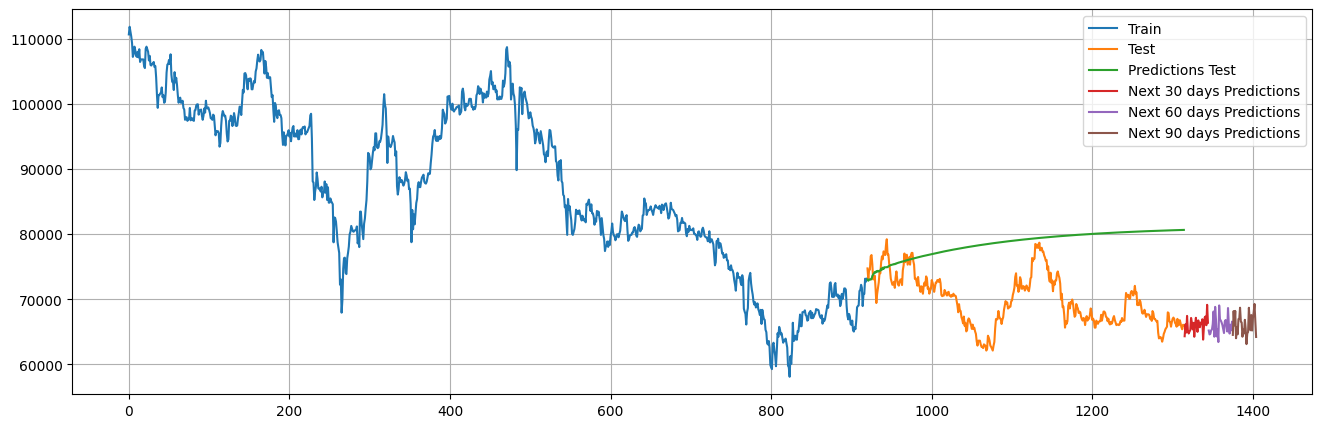

In [8]:
# Chia future_forecasts thành 30 ngày, 60 ngày và 90 ngày
predictions_30_days = future_forecasts[:30]
predictions_60_days = future_forecasts[:60]
predictions_90_days = future_forecasts[:90]

# Vẽ biểu đồ
plt.figure(figsize=(16, 5))
plt.grid(True)
plt.plot(train_data.index, train_data['Price'], label='Train')
plt.plot(test_data.index, test_data['Price'], label='Test')
plt.plot(test_data.index, y_pred, label='Predictions Test')

# Vẽ dự báo của 30 ngày, 60 ngày và 90 ngày tiếp theo
forecast_index_30 = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
forecast_index_60 = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
forecast_index_90 = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(forecast_index_30, predictions_30_days, label='Next 30 days Predictions')
plt.plot(forecast_index_60, predictions_60_days[30:], label='Next 60 days Predictions')
plt.plot(forecast_index_90, predictions_90_days[60:], label='Next 90 days Predictions')
plt.legend()
plt.show()

#4. Phân chia dữ liệu thành tập huấn luyện, kiểm tra  theo tỉ lệ 8:2

In [9]:
train_size = int(0.8 * len(df))
test_size =  len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

#5. tìm số lượng lag phù hợp cho mô hình

In [10]:
#pacf= plot_pacf(df['Price'],lags=25)
#acf= plot_acf(df['Price'],lags=25)
# Sử dụng AIC để tìm lag tốt nhất
aic_values = []
max_lag = 30  # Chọn tối đa độ trễ muốn kiểm tra

for lag in range(1, max_lag + 1):
    model = AutoReg(train_data["Price"], lags=lag).fit()
    aic_values.append(model.aic)

best_lag = np.argmin(aic_values) + 1
print(f'Lag tốt nhất theo AIC: {best_lag}')


Lag tốt nhất theo AIC: 30


#6. Dự đoán giá trong 90 ngày tới

In [11]:

# Huấn luyện mô hình AR trên tập huấn luyện
ar_model = AutoReg(train_data['Price'], lags=best_lag)
ar_model_fit = ar_model.fit()

# Dự đoán trên tập kiểm tra
y_pred = ar_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Dự đoán phần dư sử dụng mô hình AR
pred_errors = ar_model_fit.resid

# Tính toán các tham số của dự báo
mu = pred_errors.mean()
sigma = pred_errors.std()

# Dự đoán giá cho 90 ngày tiếp theo
future_forecasts = []
for i in range(90):
    future_error = np.random.normal(loc=mu, scale=sigma)
    future_forecast = test_data['Price'].iloc[-1] + future_error
    future_forecasts.append(future_forecast)

# Hiển thị kết quả
print('Predicted closing prices for the next 90 days:')
print(future_forecasts)


Predicted closing prices for the next 90 days:
[67416.1879711683, 67106.75510340348, 65280.05471083534, 64341.54972638616, 66198.67111595754, 64637.393632391315, 64965.15742775987, 64993.077688718084, 67423.26108835891, 65162.655424038385, 64640.83215399833, 65405.568475704546, 66221.48356082175, 66705.0158729812, 67578.49567345963, 66209.09179949664, 64061.469311477114, 65697.80993523484, 65908.1261450272, 65108.359502772786, 65840.01186014184, 64969.12486966037, 62723.34614681233, 66670.71769208957, 65370.593076677535, 67057.88784164055, 64760.759750843055, 68246.38139034892, 64209.360416026, 65472.12362826853, 65004.464659709214, 67953.8444085593, 67929.93777158302, 64756.43640108428, 66880.28380942268, 66722.18799344002, 64880.396430478315, 67673.97593640574, 64730.35953889856, 67763.39282697407, 64623.29901723844, 67569.94005746163, 66017.31415381316, 65777.72591335485, 64703.8815399439, 65368.67147316123, 66056.92110356803, 66124.190566716, 66319.89528392363, 65367.1574763541, 67

#7. Tính RMSE, MSE, MAPE

In [12]:
y_test = test_data['Price'].values
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

Testing RMSE: 4836.854064083393
Testing MAE: 4259.131571445495
Testing MAPE: 6.223188419711184


#8. Vẽ mô hình dự báo

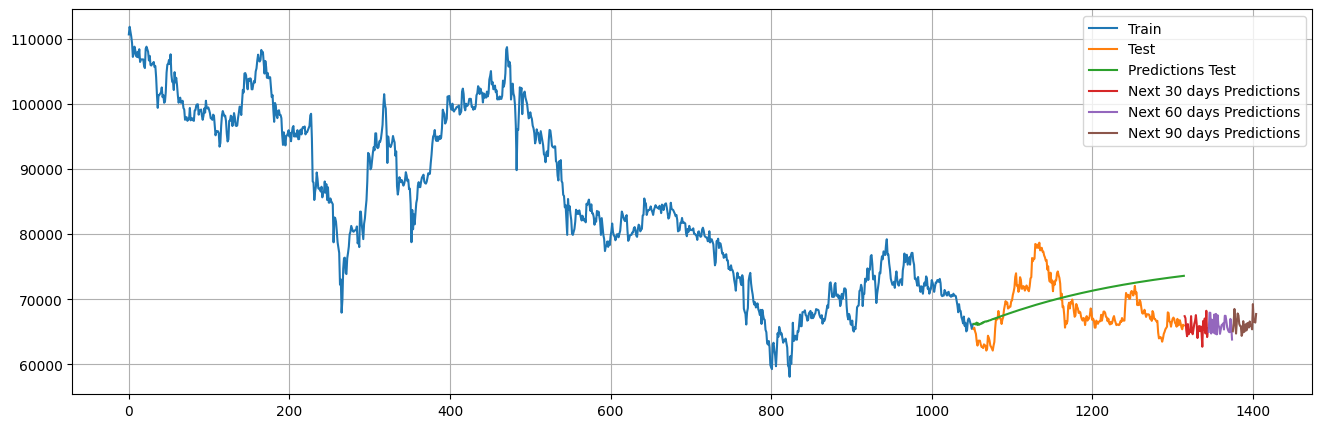

In [13]:
# Chia future_forecasts thành 30 ngày, 60 ngày và 90 ngày
predictions_30_days = future_forecasts[:30]
predictions_60_days = future_forecasts[:60]
predictions_90_days = future_forecasts[:90]

# Vẽ biểu đồ
plt.figure(figsize=(16, 5))
plt.grid(True)
plt.plot(train_data.index, train_data['Price'], label='Train')
plt.plot(test_data.index, test_data['Price'], label='Test')
plt.plot(test_data.index, y_pred, label='Predictions Test')

# Vẽ dự báo của 30 ngày, 60 ngày và 90 ngày tiếp theo
forecast_index_30 = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
forecast_index_60 = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
forecast_index_90 = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(forecast_index_30, predictions_30_days, label='Next 30 days Predictions')
plt.plot(forecast_index_60, predictions_60_days[30:], label='Next 60 days Predictions')
plt.plot(forecast_index_90, predictions_90_days[60:], label='Next 90 days Predictions')
plt.legend()
plt.show()

#4. Phân chia dữ liệu thành tập huấn luyện, kiểm tra  theo tỉ lệ 9:1

In [14]:
train_size = int(0.9 * len(df))
test_size =  len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

#5. tìm số lượng lag phù hợp cho mô hình

In [15]:
#pacf= plot_pacf(df['Price'],lags=25)
#acf= plot_acf(df['Price'],lags=25)
# Sử dụng AIC để tìm lag tốt nhất
aic_values = []
max_lag = 30  # Chọn tối đa độ trễ muốn kiểm tra

for lag in range(1, max_lag + 1):
    model = AutoReg(train_data["Price"], lags=lag).fit()
    aic_values.append(model.aic)

best_lag = np.argmin(aic_values) + 1
print(f'Lag tốt nhất theo AIC: {best_lag}')


Lag tốt nhất theo AIC: 30


#6. Dự đoán giá trong 90 ngày tới

In [16]:

# Huấn luyện mô hình AR trên tập huấn luyện
ar_model = AutoReg(train_data['Price'], lags=best_lag)
ar_model_fit = ar_model.fit()

# Dự đoán trên tập kiểm tra
y_pred = ar_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Dự đoán phần dư sử dụng mô hình AR
pred_errors = ar_model_fit.resid

# Tính toán các tham số của dự báo
mu = pred_errors.mean()
sigma = pred_errors.std()

# Dự đoán giá cho 90 ngày tiếp theo
future_forecasts = []
for i in range(90):
    future_error = np.random.normal(loc=mu, scale=sigma)
    future_forecast = test_data['Price'].iloc[-1] + future_error
    future_forecasts.append(future_forecast)

# Hiển thị kết quả
print('Predicted closing prices for the next 90 days:')
print(future_forecasts)


Predicted closing prices for the next 90 days:
[66780.59675122818, 66833.10017100991, 66297.8394273862, 65122.63195071364, 65240.980221563215, 65683.8185621284, 66641.2266572214, 65369.12370165193, 66808.95467409815, 66000.85730609109, 68797.41593323779, 64752.25383821803, 68153.47798816064, 65677.96887785461, 66336.81818626559, 65414.23590950497, 66894.43992208646, 66614.38344344357, 65290.263216792104, 64298.440024995725, 66251.59976221427, 64597.244259845815, 65145.38011646603, 66611.84857526394, 63856.41987651669, 65750.09412033824, 65261.34481071913, 65464.038320897576, 66091.48314588473, 67309.42764745987, 65085.613351518645, 65498.110765842895, 66420.78609796884, 65526.60818117123, 66335.84427591242, 64395.148330094504, 66371.07667261608, 66458.89024312916, 66939.45295966098, 64972.550538398995, 67124.39553562156, 67891.02501538655, 67844.04853037435, 66358.18006617721, 65163.55451163326, 65464.70811973814, 66346.08697993172, 65853.89989557106, 66291.6557564405, 64003.6684805983

#7. Tính RMSE, MSE, MAPE

In [17]:
y_test = test_data['Price'].values
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

Testing RMSE: 4020.650590418304
Testing MAE: 3404.029135521232
Testing MAPE: 5.126521240133474


#8. Vẽ mô hình dự báo

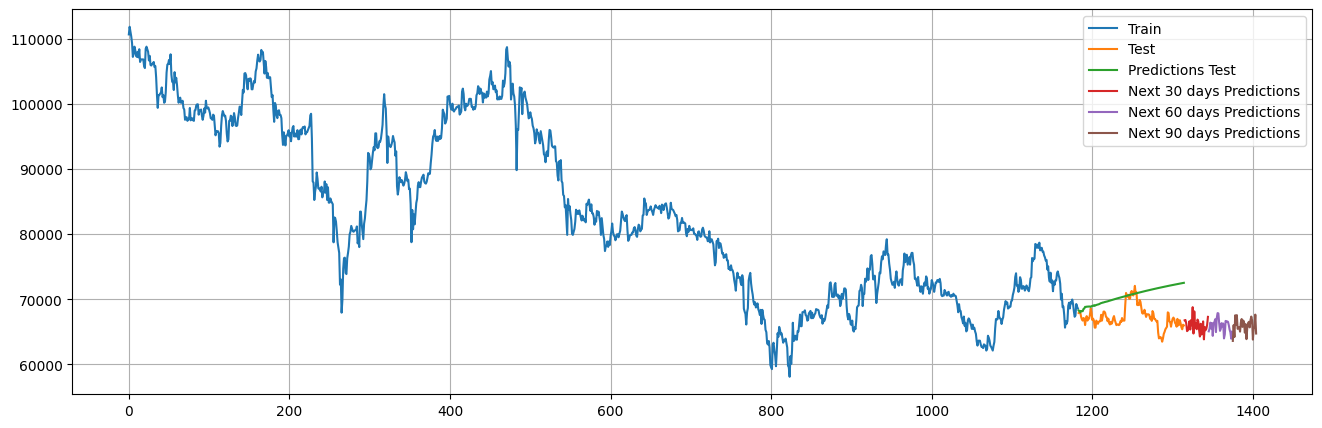

In [18]:
# Chia future_forecasts thành 30 ngày, 60 ngày và 90 ngày
predictions_30_days = future_forecasts[:30]
predictions_60_days = future_forecasts[:60]
predictions_90_days = future_forecasts[:90]

# Vẽ biểu đồ
plt.figure(figsize=(16, 5))
plt.grid(True)
plt.plot(train_data.index, train_data['Price'], label='Train')
plt.plot(test_data.index, test_data['Price'], label='Test')
plt.plot(test_data.index, y_pred, label='Predictions Test')

# Vẽ dự báo của 30 ngày, 60 ngày và 90 ngày tiếp theo
forecast_index_30 = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
forecast_index_60 = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
forecast_index_90 = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(forecast_index_30, predictions_30_days, label='Next 30 days Predictions')
plt.plot(forecast_index_60, predictions_60_days[30:], label='Next 60 days Predictions')
plt.plot(forecast_index_90, predictions_90_days[60:], label='Next 90 days Predictions')
plt.legend()
plt.show()